In [4]:
# Start writing code here...
!pip install wbgapi

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [34]:
import csv
import numpy as np
import pandas as pd
import wbgapi as wb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.featureselection import 

%matplotlib inline

In [7]:
def get_all_indicator_codes():
    '''
    (Helper function) Get list of code/id's for all indicators.
    '''
    return [row['id'] for row in wb.series.list(db=2)] # 2 specifies WDI

def get_iso_code(country):
    '''
    (Helper function) Get iso code for country.

    country (string) -- country to get iso code for
    '''
    iso_code = wb.economy.coder(country)

    if iso_code is None:
        print("ERROR: get_iso_code could not resolve country name.")
        return None
    else:
        return iso_code

def get_specific_indicator_code(keyword):
    '''
    (Helper function) Get specific codes for indicators related to a keyword

    keyword (string) -- keyword to get codes for
    '''

    indicator_codes = wb.series.info(q=keyword)

    if indicator_codes is None:
        print("ERROR: indicator_codes could not resolve keyword argument.")
        return None
    else:
        return indicator_codes
        
def get_indicators_for_country(country, min_year=None, max_year=None):
    '''
    Get set (generator) of indicators for specific country.
    This is a generator function, as it returns a generator object.

    country (string) -- country specified to get indicators for
    min_year (4-digit int) -- start year of data coverage consideration (only
                              used if max_year also available)
    max_year (4-digit int) -- end year of data coverage consideration (only
                              used if max_year also available)   
    '''
    joined_indicator_codes = ';'.join(get_all_indicator_codes()) # joined for refetch fxn
    country_iso_code = get_iso_code(country)
    
    if country_iso_code is None:
        return [] # no error print needed as one will be printed in get_iso_code

    if min_year is not None and max_year is not None:
        ind_generator = wb.refetch('sources/{source}/series/{series}/country/{economy}', \
            ['series', 'economy'], source=2, series=joined_indicator_codes, \
            economy=country_iso_code, time=range(min_year, max_year, 1))
    else:
       ind_generator = wb.refetch('sources/{source}/series/{series}/country/{economy}', \
            ['series', 'economy'], source=2, series=joined_indicator_codes, \
            economy=country_iso_code) 

    return ind_generator

def filter_indicators_by_coverage(ind_generator, threshold=0.0):
    '''
    Get set of indicators filtered by data coverage. Indicators that
    have data coverage equal to or above 'threshold' will be included.

    Deciding against converting the generator into a dataframe and just iterating
    due to immense size of data; it will probably be more efficient iterating
    than manipulating the large dataframe for each unique indicator.

    ind_generator (generator) -- list of indicators and their respective values
    threshold (float) -- minimum data coverage amount                         
    '''
    filtered_ind = set()
    prev_ind_code = None
    num_nan = 0
    num_total = 0

    for row in ind_generator:
        curr_ind_code = row['variable'][0]['id']
        curr_value = row['value']

        # calculate stats for prev indicator
        if curr_ind_code != prev_ind_code and prev_ind_code is not None:

            coverage_percentage = (num_total - num_nan) / num_total
            if coverage_percentage >= threshold:
                filtered_ind.add(prev_ind_code)

            num_nan = 0
            num_total = 0

        if curr_value is None:
            num_nan += 1
        num_total += 1
        prev_ind_code = curr_ind_code

    return list(filtered_ind)

def export_array(arr, filename):
    '''
    Exports array of values into a CSV file.

    arr (array) -- array of values to export
    filename (string) -- name of file to export to, including ".csv"
    '''
    # reshape file for export formatting
    len_arr = len(arr)

    if len_arr == 0:
        print("ERROR: export_array cannot convert empty data.")
        return

    reshaped_arr = np.array(arr).reshape((len_arr, 1))

    file = open(filename, 'w+', newline ='')

    with file:     
        write = csv.writer(file) 
        write.writerows(reshaped_arr)
    file.close()

    
if __name__ == "__main__":
    '''
    The Main Function of this file, where execution starts.
    '''
    fetched_ind = get_indicators_for_country('Colombia', 1980, 2010)
    filtered_ind = filter_indicators_by_coverage(fetched_ind, 0.90)
    print(len(filtered_ind))
    export_array(filtered_ind, 'NEW_col_data_90_threshold.csv')

300


In [30]:
fetched_ind = get_indicators_for_country('Colombia', 1980, 2010)
filtered_ind = filter_indicators_by_coverage(fetched_ind, 0.90)


['NV.IND.TOTL.KN', 'SP.POP.1014.FE.5Y', 'NV.MNF.MTRN.ZS.UN', 'MS.MIL.XPND.GD.ZS', 'NE.GDI.STKB.CN', 'NY.GDP.PCAP.CN', 'SP.POP.0014.FE.IN', 'TM.VAL.MRCH.WR.ZS', 'NV.IND.MANF.CD', 'NY.GDP.PCAP.KD.ZG', 'SP.POP.4549.FE.5Y', 'SP.POP.1519.MA.5Y', 'SP.ADO.TFRT', 'FM.AST.NFRG.CN', 'NE.CON.PRVT.PC.KD.ZG', 'FM.AST.CGOV.ZG.M3', 'SP.POP.3034.FE.5Y', 'NY.GNP.MKTP.CD', 'SP.POP.0509.MA.5Y', 'BX.GRT.TECH.CD.WD', 'AG.LND.CROP.ZS', 'TX.VAL.MRCH.OR.ZS', 'TX.VAL.MRCH.R4.ZS', 'SP.POP.7579.FE.5Y', 'TX.VAL.MRCH.CD.WT', 'NY.GDP.DISC.CN', 'NE.IMP.GNFS.CD', 'SP.POP.5559.MA.5Y', 'NE.CON.PRVT.KD', 'SP.POP.GROW', 'SP.POP.7074.MA.5Y', 'FM.AST.PRVT.ZG.M3', 'NV.SRV.TOTL.ZS', 'NE.CON.TOTL.KN', 'SP.URB.TOTL.IN.ZS', 'NY.GDP.MKTP.KD', 'NY.TTF.GNFS.KN', 'NE.CON.TOTL.KD', 'NE.TRD.GNFS.ZS', 'NY.GDP.PCAP.KN', 'SP.DYN.AMRT.MA', 'NE.DAB.TOTL.ZS', 'TM.VAL.MRCH.CD.WT', 'AG.SRF.TOTL.K2', 'DT.ODA.ODAT.PC.ZS', 'NV.AGR.TOTL.ZS', 'SP.POP.2024.MA.5Y', 'TM.VAL.MRCH.OR.ZS', 'NY.TAX.NIND.CN', 'SP.POP.TOTL', 'NE.GDI.FTOT.CD', 'NY.GDS.TOTL

In [36]:
df = wb.data.DataFrame(filtered_ind, 'COL', time=range(1980, 2020), skipBlanks=True, columns='series')


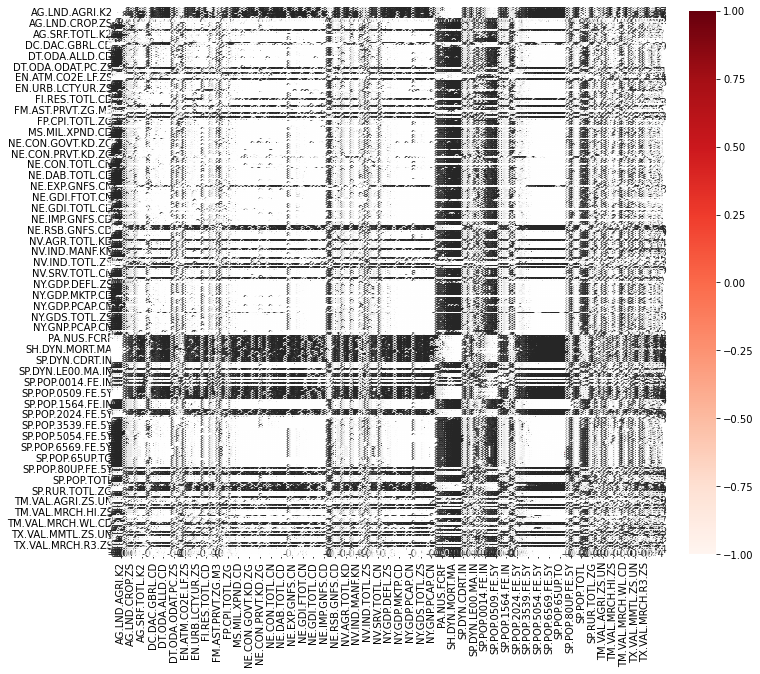

In [37]:
X = df.drop("NY.GDP.PCAP.CN",1)   #Feature Matrix
y = df["NY.GDP.PCAP.CN"]          #Target Variable
df.head()
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [39]:
#Correlation with output variable
cor_target = abs(cor["NY.GDP.PCAP.CN"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.9]
relevant_features

AG.PRD.CROP.XD       0.925112
AG.PRD.FOOD.XD       0.950669
AG.PRD.LVSK.XD       0.948405
AG.YLD.CREL.KG       0.929382
BX.GRT.EXTA.CD.WD    0.926723
                       ...   
TM.VAL.MRCH.CD.WT    0.948011
TM.VAL.MRCH.HI.ZS    0.937363
TM.VAL.MRCH.OR.ZS    0.995940
TM.VAL.MRCH.R1.ZS    0.994393
TM.VAL.MRCH.WL.CD    0.946125
Name: NY.GDP.PCAP.CN, Length: 158, dtype: float64

In [14]:
print(thresholded_country_data)

        NY.GDP.MKTP.CD
0    SP.POP.65UP.MA.ZS
1       NE.GDI.TOTL.KD
2       NE.DAB.TOTL.KN
3       NY.GDS.TOTL.CN
4    TM.VAL.MRCH.RS.ZS
..                 ...
294  SP.POP.5559.FE.5Y
295  SP.POP.7074.FE.5Y
296     DT.ODA.ALLD.KD
297  FM.LBL.BMNY.IR.ZS
298     NE.CON.TOTL.ZS

[299 rows x 1 columns]


In [52]:
get_iso_code('Colombia')

'COL'

In [29]:
print(thresholded_country_data.T)

<bound method NDFrame.head of                               0               1               2    \
NY.GDP.MKTP.CD  SP.POP.65UP.MA.ZS  NE.GDI.TOTL.KD  NE.DAB.TOTL.KN   

                           3                  4                  5    \
NY.GDP.MKTP.CD  NY.GDS.TOTL.CN  TM.VAL.MRCH.RS.ZS  TX.VAL.MANF.ZS.UN   

                           6                  7               8    \
NY.GDP.MKTP.CD  AG.LND.CREL.HA  TX.VAL.MRCH.AL.ZS  FI.RES.XGLD.CD   

                           9    ...             289          290  \
NY.GDP.MKTP.CD  DC.DAC.JPNL.CD  ...  NE.GDI.TOTL.ZS  PA.NUS.FCRF   

                              291             292             293  \
NY.GDP.MKTP.CD  SP.POP.65UP.MA.IN  EN.ATM.CO2E.KT  NY.GDP.MKTP.KN   

                              294                295             296  \
NY.GDP.MKTP.CD  SP.POP.5559.FE.5Y  SP.POP.7074.FE.5Y  DT.ODA.ALLD.KD   

                              297             298  
NY.GDP.MKTP.CD  FM.LBL.BMNY.IR.ZS  NE.CON.TOTL.ZS  

[1 rows x 299 columns

In [46]:
def indicator_dataframe(country, target_indicator_code, start_year, end_year, coverage_threshold):
    '''
    country (string) -- The country of interest.
    target_indicator_code (string) -- The specific indicator code for the target indicator.
    start_year (int) -- The earliest year of interest.
    end_year (int) -- The latest year of interest.
    coverage_threshold -- The required indicator coverage threshold. For example, if it is 0.9, then there must exist data for 90% of the selected years.
    '''
    fetched_ind = get_indicators_for_country('Country', start_year, end_year)
    filtered_ind = filter_indicators_by_coverage(fetched_ind, coverage_threshold)
    country_code = get_iso_code(country)
    df = wb.data.DataFrame(filtered_ind, country_code, time=range(start_year, end_year), skipBlanks=True, columns='series')
    
    return df

In [56]:
print(get_specific_indicator_code('lifespan'))

In [60]:
def pearson_correlation_feature_selection(country, target_indicator_code, start_year, end_year, coverage_threshold = 0.9, corr_threshold = 0.8):
    '''
    Generates the pearson correlation matrix between a target indicator and all other indicators for a country.
    Then, remove the indicators that fail to meet a pre-determined correlation threshold.

    country (string) -- The country of interest.
    target_indicator_code (string) -- The specific indicator code for the target indicator.
    start_year (int) -- The earliest year of interest.
    end_year (int) -- The latest year of interest.
    coverage_threshold (float) -- The required indicator coverage threshold. For example, if it is 0.9, then there must exist data for 90% of the selected years.
    corr_threshold (float) -- A correlation threshold that an indicator must meet with the target indicator in order to not be removed.
    
    '''
    if abs(corr_threshold) > 1.0:
        print("ERROR: Correlation threshold must be between -1 and 1")
        return None

    country_code = get_iso_code(country)

    df = indicator_dataframe(country_code, target_indicator_code, start_year, end_year, coverage_threshold)

    
    X = df.drop(target_indicator_code,1) #Feature Matrix
    y = df[target_indicator_code] #Target Variable

    cor = df.corr()
    plt.figure(figsize=(12,10)) #Plot the correlation matrix
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)  
    plt.show()

    cor_target = abs(cor[target_indicator_code]) #Correlation with target variable
    relevant_features = cor_target[cor_target>0.5]  #Select the indicators that meet the threshold
    return list(relevant_features)



    


In [61]:
pearson_correlation_feature_selection('Colombia', 'NY.GDP.PCAP.CN', 1980, 2010, 0.9, 0.9)

ERROR: get_iso_code could not resolve country name.


APIError: APIError: [404] Not Found (https://api.worldbank.org/v2/en/sources/2/series//country/COL/time/YR1980;YR1981;YR1982;YR1983;YR1984;YR1985;YR1986;YR1987;YR1988;YR1989;YR1990;YR1991;YR1992;YR1993;YR1994;YR1995;YR1996;YR1997;YR1998;YR1999;YR2000;YR2001;YR2002;YR2003;YR2004;YR2005;YR2006;YR2007;YR2008;YR2009?per_page=1000&page=1&format=json)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=72b1e015-02d7-48b2-beb6-dcae4caaa79e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>